# Running QuAIRKit with third-party quantum cloud platforms

QuAIRKit as a quantum algorithm SDK does not provide access to its own quantum hardware or quantum hardware emulation. Instead, it allows users to run quantum algorithms with backends set to third-party quantum cloud providers. This tutorial will show how to run quantum circuits in QuAIRKit with backend linked to third-party quantum clouds for access to real quantum hardwares and quantum circuit emulations.

**Table of contents**

- [Backend setup](#backend-setup)
- [VQE with quantum cloud backend](#vqe-with-quantum-cloud-backend)

In [12]:
import time
from typing import Dict

import numpy as np
from matplotlib import pyplot as plt
import torch

import quairkit as qkit
from quairkit import Circuit, StateOperator, Hamiltonian
from quairkit.database import *
from quairkit.loss import *
from quairkit.qinfo import *

## Backend setup

The example cloud platform for this tutorial is the Tencent quantum cloud. One needs to first install the [TensorCircuit](https://github.com/tencent-quantum-lab/tensorcircuit) SDK. Note that TensorCircuit v0.12.0 is not compatible with the newest version of Numpy (v2.2.6), so we need to install an older version of Numpy (less than v2.0.0) to avoid potential issues.

```bash
pip install "tensorcircuit[cloud]"
pip install "numpy<2.0.0"
```

The cloud platform is accessed via a token. Please contact Tencent quantum cloud for more details.

In [ ]:
import tensorcircuit as tc

from tensorcircuit.cloud import apis
apis.set_token("ENTER YOUR TOKEN HERE")
print("List of available backends in quantum cloud:\n", apis.list_devices())

Please first ``pip install -U cirq`` to enable related functionality in translation module


List of available backends in quantum cloud:
 [tencent::tianxuan_s2v20s1, tencent::tianxuan_s2, tencent::tianji_m2, tencent::tianji_m1v15s1, tencent::tianji_m1v15s2, tencent::tianji_m2v14s2, tencent::tianji_m1v15s4, tencent::tianji_m2v14s4, tencent::tianji_s2v7, tencent::tianxuan_s2v20s2, tencent::tianji_m1v15s3, tencent::tianji_s2, tencent::tianji_m2v15s3, tencent::tianji_m2v16s1, tencent::tianxuan_s1, tencent::simulator:tc, tencent::tianji_s2v6]


Hardware-like backends in QuAIRKit can be set via an abstract class `StateOperator`. Such class provides a unified interface for quantum hardware and quantum circuit emulations. By implementing an abstract method `_execute` on how to run quantum circuits (via [OpenQASM 2.0](https://github.com/openqasm/openqasm/tree/OpenQASM2.x)), one can initialize a backend for quantum circuit execution and gradient back-propagations.

In [ ]:
class TensorCircuitState(StateOperator):
    r"""Tensor Circuit backend for QuAIRKit linked to the Tencent quantum cloud.
    """
    backend = "TensorCircuit" # need to specify the backend name
    DEVICE = "simulator:tc" # or any available backend list above
    
    def clone(self):
        return TensorCircuitState(self._data, self._sys_dim)
    
    def _execute(self, qasm: str, shots: int) -> Dict[str, int]:
        r"""IMPLEMENT HERE to execute the circuit on the quantum cloud.
        
        Args:
            qasm: The OpenQASM string of the circuit to be executed.
            shots: The number of shots for the execution.
            
        Returns:
            A dictionary storing the number of each measurement outcomes.
            The keys are the outcome digits in binary string, and the values are the number of occurrences.
         
        """
        circuit = tc.Circuit.from_openqasm(qasm)
        job = apis.submit_task(
            device=self.DEVICE,
            circuit=circuit,
            shots=shots,
        )
        return job.results()

This backend can be setup for QuAIRKit as follows:

In [4]:
qkit.set_backend(TensorCircuitState)

Then everything is done! One is now ready to run quantum circuits in QuAIRKit with backend linked to the Tencent quantum cloud. Note that for hardware backends, the only supported functionals are measurement and expectation values. Other functionals such as state tomography and process tomography are not supported.

## VQE with quantum cloud backend

The task of variational quantum eigensolver (VQE) is to find the ground state energy of a given Hamiltonian. Here we show how to run a two-qubit VQE algorithm with backend linked to the Tencent quantum cloud.

One first setup the circuit.

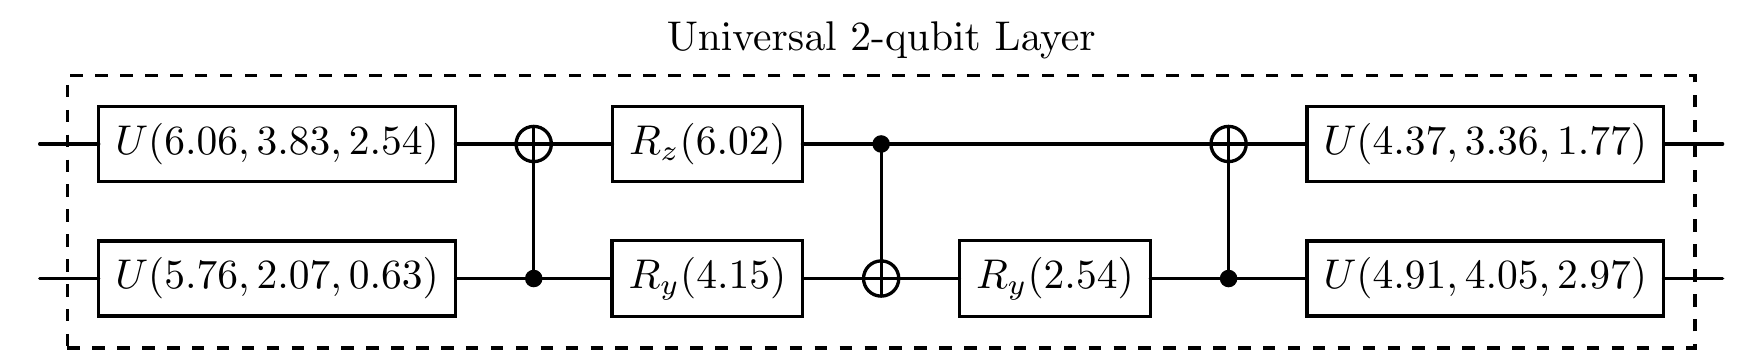

In [5]:
num_qubits = 2

cir = Circuit(num_qubits)
cir.universal_two_qubits([0, 1])
cir.plot()

For simplicity we consider a simple two-qubit Hamiltonian.

In [6]:
H = Hamiltonian([[-0.7043555077309385, 'X0,X1'],
                 [0.5622440411152363, 'Z1'],
                 [0.8027719220098997, 'Z0']])

lambda_0 = torch.linalg.eigvalsh(H.matrix).min().item()
print("Ground state energy:", lambda_0)

Ground state energy: -1.5360291004180908


As for initial states, note that one cannot easily initialize a random state on real quantum hardwares. QuAIRKit provides initialization to computational states.

In [7]:
# input_state = computational_state(num_qubits, index=3) # |3> = |11>
input_state = zero_state(num_qubits)

The loss function is defined as the expectation value with respect to the Hamiltonian. The grammar here is as usual in QuAIRKit.

In [8]:
def loss_fcn(circuit: Circuit) -> torch.Tensor:
    return circuit(input_state).expec_val(H, shots=10000)

The learning rate is set to 0.1 and the number of iterations is set to 25.

In [9]:
LR, NUM_ITR = 0.1, 25

For the gradient update, the gradient is computed via the generalized parameter-shift rule [1] or finite-difference method, depending on how operators in the circuit are parameterized.

In [10]:
loss_list, time_list = [], []

opt = torch.optim.Adam(lr=LR, params=cir.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5) # activate scheduler

for itr in range(NUM_ITR):
    start_time = time.time()
    opt.zero_grad()

    loss = loss_fcn(cir) # compute loss

    loss.backward()
    opt.step()

    loss = loss.item()
    scheduler.step(loss) # activate scheduler
    
    loss_list.append(loss)
    time_list.append(time.time() - start_time)

    if itr % (NUM_ITR // 5) == 0 or itr == NUM_ITR - 1:
        print(f"iter: {str(itr).zfill(len(str(NUM_ITR)))}, " +
              f"loss: {loss:.8f}, " +
              f"lr: {scheduler.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s")
        time_list = []

iter: 00, loss: -0.62908894, lr: 1.00E-01, avg_time: 370.0089s
iter: 05, loss: -1.19858003, lr: 1.00E-01, avg_time: 367.4510s
iter: 10, loss: -1.45725131, lr: 1.00E-01, avg_time: 371.2424s
iter: 15, loss: -1.47504807, lr: 1.00E-01, avg_time: 369.3047s
iter: 20, loss: -1.48539484, lr: 1.00E-01, avg_time: 369.2584s
iter: 24, loss: -1.51974654, lr: 1.00E-01, avg_time: 370.2565s


As shown below, the loss value approaches the ground state energy of the Hamiltonian.

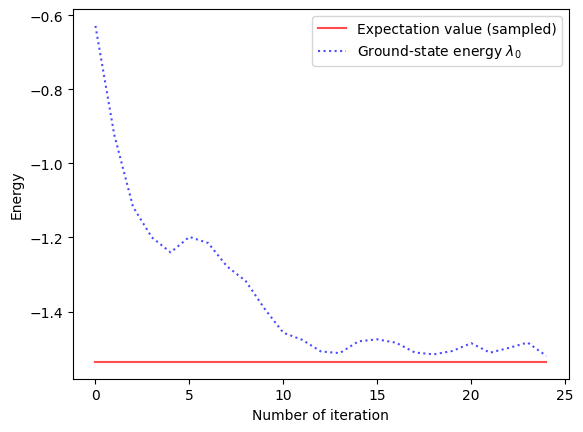

In [13]:
list_itr = list(range(NUM_ITR))
plt.plot(
    list_itr,
    lambda_0 * torch.ones(NUM_ITR),
    alpha=0.7,
    marker="",
    linestyle="-",
    color="r",
    label=r"Expectation value (sampled)",
)

plt.plot(
    list_itr,
    loss_list,
    alpha=0.7,
    marker="",
    linestyle=":",
    color="b",
    label=r"Ground-state energy $\lambda_0$",
)
plt.xlabel("Number of iteration")
plt.ylabel(r"Energy")
plt.legend(loc="best")
plt.show()

---

In [14]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.1
torch: 2.8.0+cpu
numpy: 1.26.4
scipy: 1.15.3
matplotlib: 3.10.5
---------SYSTEM---------
Python version: 3.10.18
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
